Загрузка датасета 

In [3]:
import cv2
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.optimizers import Adam

train_path = pathlib.Path("Images")
val_path = pathlib.Path("Test")

img_h = 224
img_w = 224

train_data = tf.keras.utils.image_dataset_from_directory(train_path)
val_data = tf.keras.utils.image_dataset_from_directory(val_path)
class_labels = dict(zip(train_data.class_names, range(len(train_data.class_names))))
num_labels = len(class_labels)

Found 18179 files belonging to 120 classes.
Found 2401 files belonging to 120 classes.


Предобработка изображений

In [4]:
augmenter = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_gen = augmenter.flow_from_directory(train_path,
                                          target_size=(img_h, img_w),
                                          color_mode="rgb",
                                          class_mode="categorical",
                                          batch_size=32,
                                          shuffle=True,
                                          seed=123)

val_gen = augmenter.flow_from_directory(val_path,
                                        target_size=(img_h, img_w),
                                        color_mode="rgb",
                                        class_mode="categorical",
                                        batch_size=32,
                                        shuffle=True,
                                        seed=123)

Found 18179 images belonging to 120 classes.
Found 2401 images belonging to 120 classes.


Создание и натсройка модели 

In [5]:
base_model = MobileNetV2(
    input_shape=(img_h, img_w, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg')

base_model.trainable = False

input_tensor = base_model.input
x = Dense(128, activation='relu')(base_model.output)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(num_labels, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

Компиляция модели 

In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=True,
)
model_ckpt = ModelCheckpoint('dogModelV2Big.keras',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

callbacks_list = [early_stop, model_ckpt]

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Обучение модели

In [7]:
hist = model.fit(
    train_gen, validation_data=val_gen,
    epochs=20,
    callbacks=callbacks_list)

Epoch 1/20


/home/kali/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-10 23:59:34.871747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-10 23:59:36.284651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


569/569 ━━━━━━━━━━━━━━━━━━━━ 1054s 2s/step - accuracy: 0.3703 - loss: 2.7170 - val_accuracy: 0.6464 - val_loss: 1.2148
Epoch 2/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 994s 2s/step - accuracy: 0.6720 - loss: 1.1129 - val_accuracy: 0.6593 - val_loss: 1.1257
Epoch 3/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 568s 980ms/step - accuracy: 0.7020 - loss: 0.9773 - val_accuracy: 0.6760 - val_loss: 1.0952
Epoch 4/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 558s 973ms/step - accuracy: 0.7205 - loss: 0.9241 - val_accuracy: 0.6776 - val_loss: 1.1116
Epoch 5/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 556s 970ms/step - accuracy: 0.7379 - loss: 0.8658 - val_accuracy: 0.6893 - val_loss: 1.0636
Epoch 6/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 539s 939ms/step - accuracy: 0.7456 - loss: 0.8299 - val_accuracy: 0.6851 - val_loss: 1.0791
Epoch 7/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 537s 937ms/step - accuracy: 0.7588 - loss: 0.7779 - val_accuracy: 0.6914 - val_loss: 1.0814
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 5.


Оценка модели 

In [8]:
(eval_loss, eval_acc) = model.evaluate(val_gen)

train_loss_vals = hist.history['loss']
val_loss_vals = hist.history['val_loss']
train_acc_vals = hist.history['accuracy']
val_acc_vals = hist.history['val_accuracy']

76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 895ms/step - accuracy: 0.6880 - loss: 1.0903


Визуализация результатов 

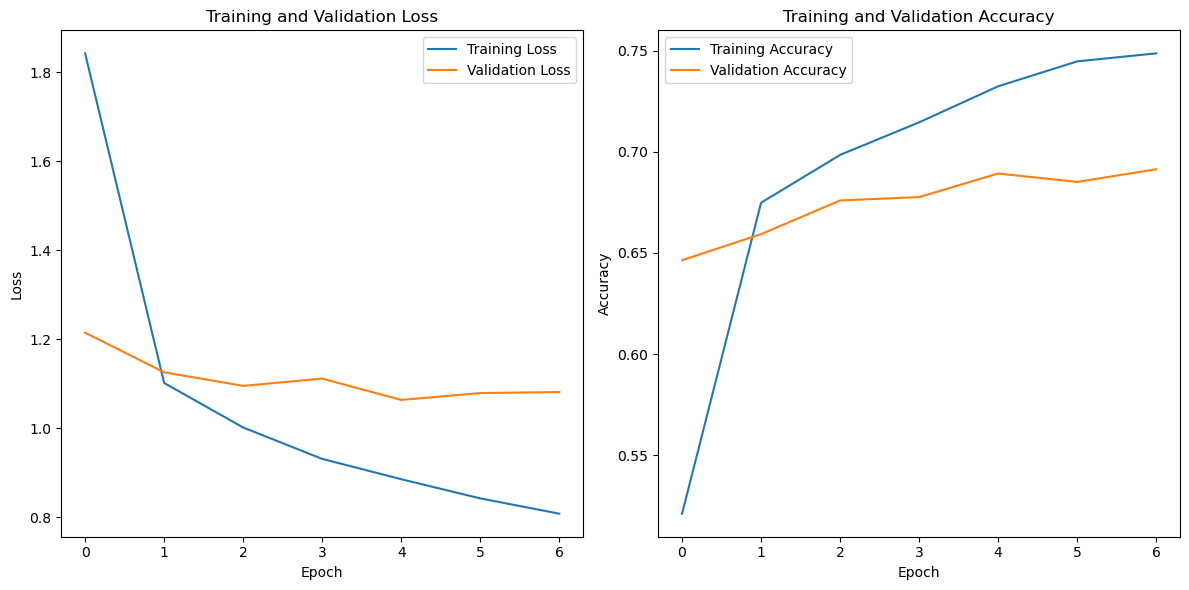

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_vals, label='Training Loss')
plt.plot(val_loss_vals, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_vals, label='Training Accuracy')
plt.plot(val_acc_vals, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Загрузка классмодели и классов 

In [11]:
model_path = 'dogModelV2Big.keras'
model = tf.keras.models.load_model(model_path)

class_names = {
        0: 'affenpinscher',
        1: 'afghan_hound',
        2: 'african_hunting_dog',
        3: 'airedale',
        4: 'american_staffordshire_terrier',
        5: 'appenzeller',
        6: 'australian_terrier',
        7: 'basenji',
        8: 'basset',
        9: 'beagle',
        10: 'bedlington_terrier',
        11: 'bernese_mountain_dog',
        12: 'black-and-tan_coonhound',
        13: 'blenheim_spaniel',
        14: 'bloodhound',
        15: 'bluetick',
        16: 'border_collie',
        17: 'border_terrier',
        18: 'borzoi',
        19: 'boston_bull',
        20: 'bouvier_des_flandres',
        21: 'boxer',
        22: 'brabancon_griffon',
        23: 'briard',
        24: 'brittany_spaniel',
        25: 'bull_mastiff',
        26: 'cairn',
        27: 'cardigan',
        28: 'chesapeake_bay_retriever',
        29: 'chihuahua',
        30: 'chow',
        31: 'clumber',
        32: 'cocker_spaniel',
        33: 'collie',
        34: 'curly-coated_retriever',
        35: 'dandie_dinmont',
        36: 'dhole',
        37: 'dingo',
        38: 'doberman',
        39: 'english_foxhound',
        40: 'english_setter',
        41: 'english_springer',
        42: 'entlebucher',
        43: 'eskimo_dog',
        44: 'flat-coated_retriever',
        45: 'french_bulldog',
        46: 'german_shepherd',
        47: 'german_short-haired_pointer',
        48: 'giant_schnauzer',
        49: 'golden_retriever',
        50: 'gordon_setter',
        51: 'great_dane',
        52: 'great_pyrenees',
        53: 'greater_swiss_mountain_dog',
        54: 'groenendael',
        55: 'ibizan_hound',
        56: 'irish_setter',
        57: 'irish_terrier',
        58: 'irish_water_spaniel',
        59: 'irish_wolfhound',
        60: 'italian_greyhound',
        61: 'japanese_spaniel',
        62: 'keeshond',
        63: 'kelpie',
        64: 'kerry_blue_terrier',
        65: 'komondor',
        66: 'kuvasz',
        67: 'labrador_retriever',
        68: 'lakeland_terrier',
        69: 'leonberg',
        70: 'lhasa',
        71: 'malamute',
        72: 'malinois',
        73: 'maltese_dog',
        74: 'mexican_hairless',
        75: 'miniature_pinscher',
        76: 'miniature_poodle',
        77: 'miniature_schnauzer',
        78: 'newfoundland',
        79: 'norfolk_terrier',
        80: 'norwegian_elkhound',
        81: 'norwich_terrier',
        82: 'old_english_sheepdog',
        83: 'otterhound',
        84: 'papillon',
        85: 'pekinese',
        86: 'pembroke',
        87: 'pomeranian',
        88: 'pug',
        89: 'redbone',
        90: 'rhodesian_ridgeback',
        91: 'rottweiler',
        92: 'saint_bernard',
        93: 'saluki',
        94: 'samoyed',
        95: 'schipperke',
        96: 'scotch_terrier',
        97: 'scottish_deerhound',
        98: 'sealyham_terrier',
        99: 'shetland_sheepdog',
        100: 'shih-tzu',
        101: 'siberian_husky',
        102: 'silky_terrier',
        103: 'soft-coated_wheaten_terrier',
        104: 'staffordshire_bullterrier',
        105: 'standard_poodle',
        106: 'standard_schnauzer',
        107: 'sussex_spaniel',
        108: 'tibetan_mastiff',
        109: 'tibetan_terrier',
        110: 'toy_poodle',
        111: 'toy_terrier',
        112: 'vizsla',
        113: 'walker_hound',
        114: 'weimaraner',
        115: 'welsh_springer_spaniel',
        116: 'west_highland_white_terrier',
        117: 'whippet',
        118: 'wire-haired_fox_terrier',
        119: 'yorkshire_terrier'
}

Функция для классификации

In [12]:
def predict_image(image_path):
    if not os.path.exists(image_path):
        print(f"Файл {image_path} не найден.")
        return "File not found"

    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось загрузить изображение {image_path}.")
        return "Failed to load image"

    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    predicted_label = class_names.get(predicted_class, "Unknown class")

    return predicted_label

Классификация пород 

In [19]:
import os

image_paths = ['poodle.jpeg', 'foxhound.jpeg']

for image_path in image_paths:
    predicted_label = predict_image(image_path)
    print(f"Предсказанный класс для {image_path}: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Предсказанный класс для poodle.jpeg: miniature_poodle
Файл beagle.jpeg не найден.
Предсказанный класс для beagle.jpeg: File not found
